In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Cài đặt 
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.9 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import pandas as pd

df01 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_april.csv')
df02 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_october.csv')

# Ghép 2 file lại với nhau
data_filled = pd.concat([df01, df02], ignore_index=True)

# 1. Xử lý dữ liệu bị thiếu

In [20]:
# df_cleaned = data.copy()
# df_cleaned = df_cleaned.drop(columns=['B04B', 'B05B', 'B06B', 'VSB', 'CIN'])

# df_cleaned = df_cleaned[~((df_cleaned['AWS'] == -np.inf) | (df_cleaned['AWS'].isnull()))]
# df_cleaned = df_cleaned[~((df_cleaned['SLHF'] == 9999) | (df_cleaned['SSHF'] == 9999))]

In [21]:
# data_filled = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# 2. Chia train test

In [3]:
def split_data_by_multiple_ranges(df, train_ranges):
    train_mask = False
    for start, end in train_ranges:
        train_mask |= (df['datetime'] >= start) & (df['datetime'] < end)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    return train_df, test_df

def convert_rain_label(df):
    df['AWS'] = df['AWS'].apply(lambda x: 1 if x > 0 else 0)
    return df

# Gắn nhãn
df_all1 = convert_rain_label(data_filled)

# Chuyển datetime nếu chưa
df_all1['datetime'] = pd.to_datetime(df_all1['datetime'])

# Chọn các khoảng train: tháng 4/2019, 10/2019, 4/2020
train_ranges = [
    ("2019-04-01", "2019-04-30"),
    ("2019-10-01", "2019-10-31"),
    ("2020-04-01", "2020-04-30"),
]

# Tách train/test theo mốc trên
train_df, test_df = split_data_by_multiple_ranges(df_all1, train_ranges)

# Giữ lại chỉ test tháng 10/2020
test_df = test_df[
    (test_df['datetime'] >= "2020-10-01") & (test_df['datetime'] <= "2020-10-31")
]

# Kết quả
print(f"Train set: {train_df.shape}")
print(f"Test set (October 2020): {test_df.shape}")

Train set: (428242, 33)
Test set (October 2020): (207094, 33)


In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# 3. Chuẩn hóa

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 4. Chọn feature

In [6]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

In [8]:
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

In [7]:
#Performance evaluation
def print_scores(y_true, y_pred):
  print(classification_report(y_true, y_pred))

# 5. Thêm class weight

In [28]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train, y_train)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

Learning rate set to 0.136983
0:	learn: 0.5198129	total: 68.1ms	remaining: 1m 8s
1:	learn: 0.4161434	total: 127ms	remaining: 1m 3s
2:	learn: 0.3489452	total: 186ms	remaining: 1m 1s
3:	learn: 0.3113713	total: 247ms	remaining: 1m 1s
4:	learn: 0.2816391	total: 306ms	remaining: 1m
5:	learn: 0.2615813	total: 367ms	remaining: 1m
6:	learn: 0.2461991	total: 426ms	remaining: 1m
7:	learn: 0.2354892	total: 492ms	remaining: 1m 1s
8:	learn: 0.2280133	total: 555ms	remaining: 1m 1s
9:	learn: 0.2230871	total: 614ms	remaining: 1m
10:	learn: 0.2186294	total: 679ms	remaining: 1m 1s
11:	learn: 0.2156588	total: 743ms	remaining: 1m 1s
12:	learn: 0.2122695	total: 806ms	remaining: 1m 1s
13:	learn: 0.2108051	total: 860ms	remaining: 1m
14:	learn: 0.2089366	total: 922ms	remaining: 1m
15:	learn: 0.2081817	total: 976ms	remaining: 1m
16:	learn: 0.2067229	total: 1.04s	remaining: 1m
17:	learn: 0.2055117	total: 1.1s	remaining: 59.8s
18:	learn: 0.2046388	total: 1.16s	remaining: 59.9s
19:	learn: 0.2035489	total: 1.23s	r

In [29]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled, y_train)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

Learning rate set to 0.136983
0:	learn: 0.5198129	total: 62.4ms	remaining: 1m 2s
1:	learn: 0.4161434	total: 121ms	remaining: 1m
2:	learn: 0.3489452	total: 180ms	remaining: 59.9s
3:	learn: 0.3113713	total: 241ms	remaining: 60s
4:	learn: 0.2816391	total: 300ms	remaining: 59.8s
5:	learn: 0.2615813	total: 361ms	remaining: 59.9s
6:	learn: 0.2461992	total: 422ms	remaining: 59.8s
7:	learn: 0.2354893	total: 487ms	remaining: 1m
8:	learn: 0.2280133	total: 551ms	remaining: 1m
9:	learn: 0.2230871	total: 610ms	remaining: 1m
10:	learn: 0.2186295	total: 675ms	remaining: 1m
11:	learn: 0.2156588	total: 740ms	remaining: 1m
12:	learn: 0.2121366	total: 805ms	remaining: 1m 1s
13:	learn: 0.2107045	total: 861ms	remaining: 1m
14:	learn: 0.2086718	total: 924ms	remaining: 1m
15:	learn: 0.2073422	total: 988ms	remaining: 1m
16:	learn: 0.2066049	total: 1.04s	remaining: 1m
17:	learn: 0.2049944	total: 1.1s	remaining: 60s
18:	learn: 0.2042240	total: 1.16s	remaining: 59.9s
19:	learn: 0.2032209	total: 1.23s	remaining: 

In [30]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_selected, y_train)

# Predict
y_pred = cat_model.predict(X_test_selected)

print_scores(y_test, y_pred)

Learning rate set to 0.136983
0:	learn: 0.5256730	total: 48.3ms	remaining: 48.3s
1:	learn: 0.4215933	total: 99.8ms	remaining: 49.8s
2:	learn: 0.3569475	total: 148ms	remaining: 49.2s
3:	learn: 0.3121148	total: 199ms	remaining: 49.5s
4:	learn: 0.2814666	total: 251ms	remaining: 49.9s
5:	learn: 0.2600845	total: 301ms	remaining: 49.8s
6:	learn: 0.2461371	total: 351ms	remaining: 49.7s
7:	learn: 0.2372788	total: 399ms	remaining: 49.4s
8:	learn: 0.2296856	total: 447ms	remaining: 49.2s
9:	learn: 0.2234373	total: 497ms	remaining: 49.2s
10:	learn: 0.2199695	total: 542ms	remaining: 48.8s
11:	learn: 0.2165366	total: 594ms	remaining: 48.9s
12:	learn: 0.2147320	total: 644ms	remaining: 48.9s
13:	learn: 0.2123073	total: 693ms	remaining: 48.8s
14:	learn: 0.2109574	total: 743ms	remaining: 48.8s
15:	learn: 0.2093521	total: 795ms	remaining: 48.9s
16:	learn: 0.2080689	total: 847ms	remaining: 49s
17:	learn: 0.2070112	total: 897ms	remaining: 49s
18:	learn: 0.2057668	total: 949ms	remaining: 49s
19:	learn: 0.20

=> Scale cao hơn

=> Không chọn đặc trưng cao hơn

In [31]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train, y_train)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    159566
           1       0.40      0.96      0.57     47528

    accuracy                           0.66    207094
   macro avg       0.69      0.77      0.65    207094
weighted avg       0.85      0.66      0.69    207094



=> Recall cao, f1 và precision không cao lắm

In [32]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled, y_train)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    159566
           1       0.40      0.96      0.57     47528

    accuracy                           0.67    207094
   macro avg       0.69      0.77      0.65    207094
weighted avg       0.85      0.67      0.69    207094



In [33]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_selected, y_train)

# Predict
y_pred = cat_model.predict(X_test_selected)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.54      0.70    159566
           1       0.38      0.97      0.55     47528

    accuracy                           0.64    207094
   macro avg       0.68      0.75      0.62    207094
weighted avg       0.85      0.64      0.66    207094



=> Chứng tỏ với bộ tham số khác, selected ngang ngửa với scale, thấp hơn chút.

=> **train = train_scaled > selected**

CatBoost không cần chuẩn hóa.

**Nhận xét về CatBoost:**

| Thử nghiệm            | Precision lớp 1 | Recall lớp 1 | F1 lớp 1 | Nhận xét chính |
|------------------------|------------------|---------------|------------|----------------|
| CatBoost mặc định       | 0.66             | 0.47          | 0.55       | Thiên lệch lớp 0 |
| + weight 3.36          | 0.53             | 0.88          | 0.66       | Phát hiện mưa tốt hơn |
| + chuẩn hóa            | 0.52             | 0.88          | 0.65       | Không cải thiện nhiều |
| + giảm đặc trưng       | 0.51             | 0.86          | 0.64       | Hiệu quả giảm nhẹ |

* CatBoost không cần chuẩn hóa.

=> Giải pháp:
* Sử dụng Voting hoặc Stacking:
Nếu CatBoost nghiêng về phát hiện lớp 1 thì kết hợp với mô hình có xu hướng khác (như RF nghiêng về lớp 0) để có Voting hoặc Stacking ổn định hơn.

Best threshold: 0.8300000000000001, F1: 0.6805327494982668


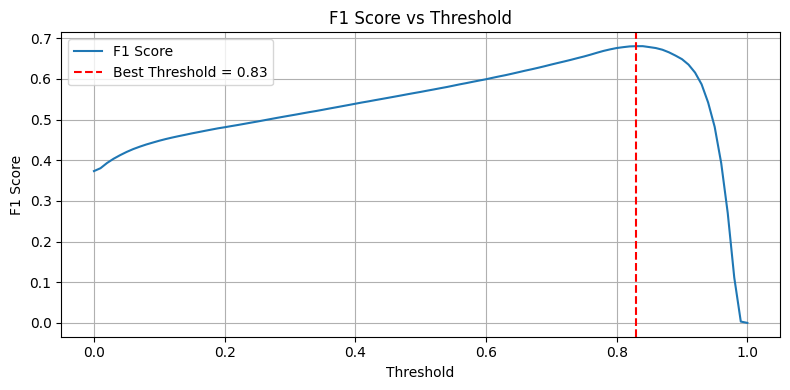

In [34]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Tuning CatBoost với Optuna**

In [35]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': SCALE_POS_WEIGHT,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-03 16:20:04,492] A new study created in memory with name: no-name-bfbe1ece-11b6-4c94-a123-2e112ccf0e9c
[I 2025-05-03 16:20:38,870] Trial 0 finished with value: 0.5913615795968736 and parameters: {'iterations': 396, 'depth': 8, 'learning_rate': 0.20854845743017317}. Best is trial 0 with value: 0.5913615795968736.
[I 2025-05-03 16:21:05,602] Trial 1 finished with value: 0.5722787961077167 and parameters: {'iterations': 352, 'depth': 7, 'learning_rate': 0.27718921297190985}. Best is trial 0 with value: 0.5913615795968736.
[I 2025-05-03 16:21:41,763] Trial 2 finished with value: 0.5821411983279146 and parameters: {'iterations': 417, 'depth': 8, 'learning_rate': 0.20398343965756408}. Best is trial 0 with value: 0.5913615795968736.
[I 2025-05-03 16:21:53,753] Trial 3 finished with value: 0.6696055946159343 and parameters: {'iterations': 228, 'depth': 4, 'learning_rate': 0.1257831249958373}. Best is trial 3 with value: 0.6696055946159343.
[I 2025-05-03 16:22:38,791] Trial 4 finishe

Best trial:
FrozenTrial(number=8, state=1, values=[0.6848688021728601], datetime_start=datetime.datetime(2025, 5, 3, 16, 25, 29, 831944), datetime_complete=datetime.datetime(2025, 5, 3, 16, 26, 3, 609315), params={'iterations': 450, 'depth': 7, 'learning_rate': 0.04662056253614243}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None)}, trial_id=8, value=None)
Best F1 Score: 0.6848688021728601
Best hyperparameters:
iterations: 450
depth: 7
learning_rate: 0.04662056253614243

Classification report with threshold = 0.8300000000000001:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89    159566
           1       0.62      0.76      0.68     47528

    accuracy                           0.84    207094
   macro avg      

In [36]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=292,
#     depth=5,
#     learning_rate=0.25030502714970054,
#     scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train, y_train)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.83
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

In [37]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_selected, y_train)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_selected)[:, 1]


y_pred = cat_model.predict(X_test_selected)
print_scores( y_test, y_pred)

y_probs = cat_model.predict_proba(X_test_selected)[:,1]

best_thresh = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

              precision    recall  f1-score   support

           0       0.98      0.54      0.70    159566
           1       0.38      0.97      0.55     47528

    accuracy                           0.64    207094
   macro avg       0.68      0.75      0.62    207094
weighted avg       0.85      0.64      0.66    207094

Best threshold: 0.8500000000000002, F1: 0.6719979457456761


In [38]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': SCALE_POS_WEIGHT,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_selected, y_train)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_selected, y_train)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_selected)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-03 16:40:54,141] A new study created in memory with name: no-name-e1442a31-86a2-4096-b138-dfff90c657b2
[I 2025-05-03 16:41:19,666] Trial 0 finished with value: 0.5654305297081385 and parameters: {'iterations': 416, 'depth': 7, 'learning_rate': 0.1725745025004446}. Best is trial 0 with value: 0.5654305297081385.
[I 2025-05-03 16:41:35,921] Trial 1 finished with value: 0.6820743975081635 and parameters: {'iterations': 267, 'depth': 7, 'learning_rate': 0.037960444005107334}. Best is trial 1 with value: 0.6820743975081635.
[I 2025-05-03 16:41:43,761] Trial 2 finished with value: 0.6725188137147214 and parameters: {'iterations': 178, 'depth': 7, 'learning_rate': 0.17182983613230102}. Best is trial 1 with value: 0.6820743975081635.
[I 2025-05-03 16:41:53,081] Trial 3 finished with value: 0.571986055465945 and parameters: {'iterations': 207, 'depth': 4, 'learning_rate': 0.011881853867753416}. Best is trial 1 with value: 0.6820743975081635.
[I 2025-05-03 16:42:00,072] Trial 4 finish

Best trial:
FrozenTrial(number=21, state=1, values=[0.6822720297076599], datetime_start=datetime.datetime(2025, 5, 3, 16, 47, 21, 685543), datetime_complete=datetime.datetime(2025, 5, 3, 16, 47, 41, 132514), params={'iterations': 277, 'depth': 8, 'learning_rate': 0.036185346750245484}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None)}, trial_id=21, value=None)
Best F1 Score: 0.6822720297076599
Best hyperparameters:
iterations: 277
depth: 8
learning_rate: 0.036185346750245484

Classification report with threshold = 0.8500000000000002:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89    159566
           1       0.62      0.76      0.68     47528

    accuracy                           0.84    207094
   macro avg 

In [39]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=336,
#     depth=6,
#     learning_rate=0.054827476508008136,
#     scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train_selected, y_train)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test_selected)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.85
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

In [40]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_train)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled)[:, 1]


y_pred = cat_model.predict(X_test_scaled)
print_scores( y_test, y_pred)

y_probs = cat_model.predict_proba(X_test_scaled)[:,1]

best_thresh = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    159566
           1       0.40      0.96      0.57     47528

    accuracy                           0.67    207094
   macro avg       0.69      0.77      0.65    207094
weighted avg       0.85      0.67      0.69    207094

Best threshold: 0.8000000000000002, F1: 0.6756195510400219


In [41]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': SCALE_POS_WEIGHT,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled, y_train)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-03 16:58:58,475] A new study created in memory with name: no-name-ee70f0e1-14b3-452b-b2b9-0d7be0b4e7d9
[I 2025-05-03 16:59:34,511] Trial 0 finished with value: 0.631236930995657 and parameters: {'iterations': 332, 'depth': 9, 'learning_rate': 0.1529882478596396}. Best is trial 0 with value: 0.631236930995657.
[I 2025-05-03 16:59:56,556] Trial 1 finished with value: 0.6701859367796871 and parameters: {'iterations': 326, 'depth': 6, 'learning_rate': 0.10773204516220038}. Best is trial 1 with value: 0.6701859367796871.
[I 2025-05-03 17:00:17,475] Trial 2 finished with value: 0.6811346638934371 and parameters: {'iterations': 392, 'depth': 4, 'learning_rate': 0.1075817937926}. Best is trial 2 with value: 0.6811346638934371.
[I 2025-05-03 17:00:38,645] Trial 3 finished with value: 0.670287356321839 and parameters: {'iterations': 284, 'depth': 7, 'learning_rate': 0.16424200176384765}. Best is trial 2 with value: 0.6811346638934371.
[I 2025-05-03 17:00:49,383] Trial 4 finished with 

Best trial:
FrozenTrial(number=11, state=1, values=[0.6852484971857574], datetime_start=datetime.datetime(2025, 5, 3, 17, 4, 0, 772354), datetime_complete=datetime.datetime(2025, 5, 3, 17, 4, 32, 76945), params={'iterations': 471, 'depth': 6, 'learning_rate': 0.05177364995849268}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None)}, trial_id=11, value=None)
Best F1 Score: 0.6852484971857574
Best hyperparameters:
iterations: 471
depth: 6
learning_rate: 0.05177364995849268

Classification report with threshold = 0.8000000000000002:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88    159566
           1       0.58      0.83      0.69     47528

    accuracy                           0.83    207094
   macro avg       

In [42]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=322,
#     depth=6,
#     learning_rate=0.1432105130052586,
#     scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train_scaled, y_train)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test_scaled)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.85
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

# 6. Cân bằng dữ liệu (Oversampling)

## 6.1 SMOTE

In [9]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [44]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_sm, y_sm)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

Learning rate set to 0.177628
0:	learn: 0.5977248	total: 115ms	remaining: 1m 55s
1:	learn: 0.5409776	total: 228ms	remaining: 1m 53s
2:	learn: 0.5025599	total: 341ms	remaining: 1m 53s
3:	learn: 0.4748894	total: 443ms	remaining: 1m 50s
4:	learn: 0.4545936	total: 552ms	remaining: 1m 49s
5:	learn: 0.4414206	total: 672ms	remaining: 1m 51s
6:	learn: 0.4301313	total: 771ms	remaining: 1m 49s
7:	learn: 0.4215192	total: 881ms	remaining: 1m 49s
8:	learn: 0.4139013	total: 987ms	remaining: 1m 48s
9:	learn: 0.4081720	total: 1.09s	remaining: 1m 48s
10:	learn: 0.4019413	total: 1.21s	remaining: 1m 49s
11:	learn: 0.3979628	total: 1.31s	remaining: 1m 48s
12:	learn: 0.3941438	total: 1.42s	remaining: 1m 47s
13:	learn: 0.3909777	total: 1.51s	remaining: 1m 46s
14:	learn: 0.3876917	total: 1.62s	remaining: 1m 46s
15:	learn: 0.3844893	total: 1.73s	remaining: 1m 46s
16:	learn: 0.3767914	total: 1.84s	remaining: 1m 46s
17:	learn: 0.3742962	total: 1.96s	remaining: 1m 46s
18:	learn: 0.3682480	total: 2.08s	remaining:

In [45]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_sm[top_features], y_sm)

# Predict
y_pred = cat_model.predict(X_test[top_features])

print_scores(y_test, y_pred)

Learning rate set to 0.177628
0:	learn: 0.6003395	total: 94.3ms	remaining: 1m 34s
1:	learn: 0.5420050	total: 187ms	remaining: 1m 33s
2:	learn: 0.5051993	total: 279ms	remaining: 1m 32s
3:	learn: 0.4782923	total: 371ms	remaining: 1m 32s
4:	learn: 0.4588882	total: 462ms	remaining: 1m 31s
5:	learn: 0.4454027	total: 554ms	remaining: 1m 31s
6:	learn: 0.4345139	total: 644ms	remaining: 1m 31s
7:	learn: 0.4255680	total: 738ms	remaining: 1m 31s
8:	learn: 0.4193471	total: 826ms	remaining: 1m 30s
9:	learn: 0.4128387	total: 911ms	remaining: 1m 30s
10:	learn: 0.4074298	total: 999ms	remaining: 1m 29s
11:	learn: 0.4029261	total: 1.09s	remaining: 1m 29s
12:	learn: 0.3992938	total: 1.17s	remaining: 1m 29s
13:	learn: 0.3962423	total: 1.26s	remaining: 1m 28s
14:	learn: 0.3932682	total: 1.35s	remaining: 1m 28s
15:	learn: 0.3902047	total: 1.43s	remaining: 1m 28s
16:	learn: 0.3878922	total: 1.52s	remaining: 1m 28s
17:	learn: 0.3816559	total: 1.62s	remaining: 1m 28s
18:	learn: 0.3797926	total: 1.71s	remaining

=> Không nên chọn đặc trưng.

In [46]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_sm, y_sm)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.45      0.62    159566
           1       0.35      0.98      0.51     47528

    accuracy                           0.57    207094
   macro avg       0.67      0.72      0.57    207094
weighted avg       0.84      0.57      0.60    207094



In [47]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_sm[top_features], y_sm)

# Predict
y_pred = cat_model.predict(X_test[top_features])

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.43      0.60    159566
           1       0.34      0.98      0.50     47528

    accuracy                           0.56    207094
   macro avg       0.66      0.71      0.55    207094
weighted avg       0.84      0.56      0.58    207094



| Cấu hình | Đặc trưng | Tùy chọn mô hình | Accuracy | F1-score lớp 1 | Nhận xét |
|----------|-----------|------------------|----------|----------------|----------|
| **SMOTE + Mặc định** | 30 | CatBoost mặc định | 0.81 | 0.59 | Kết quả tốt, cân bằng giữa hai lớp |
| **SMOTE + Mặc định** | 10 | CatBoost mặc định | 0.80 | 0.57 | Giảm nhẹ khi giảm đặc trưng |
| **SMOTE + Tuning** | 30 | 300 iter, depth=6, LR=0.05, SPW=3.36 | 0.67 | 0.57 | Accuracy thấp hơn dù precision cao |
| **SMOTE + Tuning** | 10 | như trên | 0.65 | 0.55 | Kết quả kém hơn khi giảm đặc trưng |

=> Bỏ scaled_pos_weight vì đã dùng SMOTE, không giảm đặc trưng

Best Threshold: 0.67, F1: 0.6618222683593489


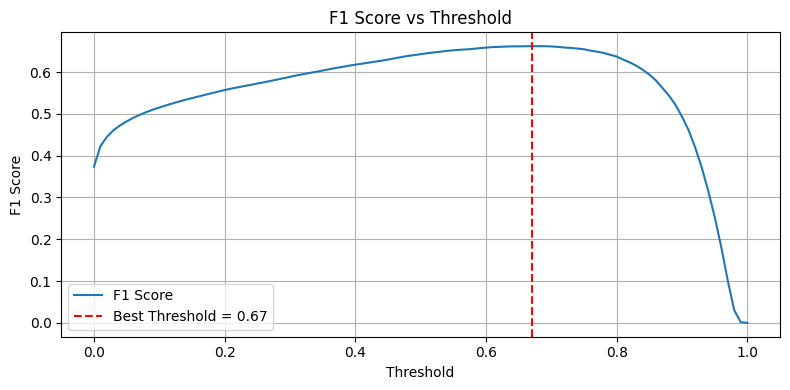

In [48]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_sm, y_sm)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, F1: {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_sm, y_sm)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_sm, y_sm)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-03 17:29:21,861] A new study created in memory with name: no-name-72301e02-9873-4f87-b405-b5a254b823ba
[I 2025-05-03 17:29:39,626] Trial 0 finished with value: 0.6441538879206915 and parameters: {'iterations': 188, 'depth': 4, 'learning_rate': 0.048841625093056826}. Best is trial 0 with value: 0.6441538879206915.
[I 2025-05-03 17:30:24,029] Trial 1 finished with value: 0.6848911343678576 and parameters: {'iterations': 434, 'depth': 5, 'learning_rate': 0.11204372194336658}. Best is trial 1 with value: 0.6848911343678576.
[I 2025-05-03 17:31:03,628] Trial 2 finished with value: 0.6688351331605232 and parameters: {'iterations': 348, 'depth': 6, 'learning_rate': 0.14898711111968727}. Best is trial 1 with value: 0.6848911343678576.
[I 2025-05-03 17:31:38,990] Trial 3 finished with value: 0.6644762984715882 and parameters: {'iterations': 245, 'depth': 8, 'learning_rate': 0.05481479929332371}. Best is trial 1 with value: 0.6848911343678576.
[I 2025-05-03 17:32:03,731] Trial 4 finis

Best trial:
FrozenTrial(number=7, state=1, values=[0.6856593737260003], datetime_start=datetime.datetime(2025, 5, 3, 17, 32, 56, 969375), datetime_complete=datetime.datetime(2025, 5, 3, 17, 33, 39, 677483), params={'iterations': 475, 'depth': 4, 'learning_rate': 0.12105844064916368}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=7, value=None)
Best F1 Score: 0.6856593737260003
Best hyperparameters:
iterations: 475
depth: 4
learning_rate: 0.12105844064916368

Classification report with threshold = 0.67:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90    159566
           1       0.64      0.74      0.69     47528

    accuracy                           0.84    207094
   macro avg       0.78      0.

Best Threshold: 0.74, F1: 0.6504416369074413


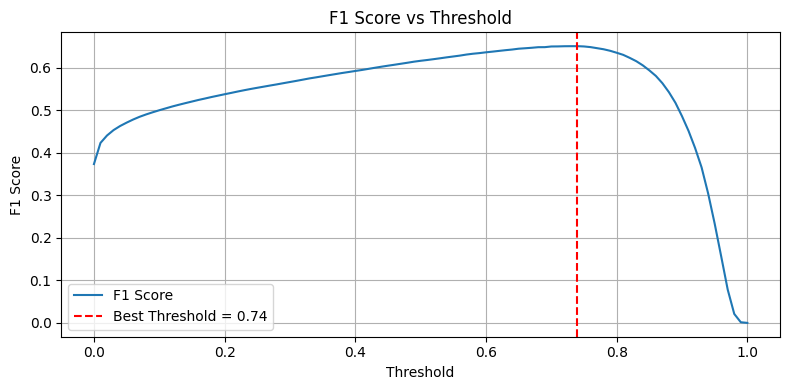

In [10]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled[top_features], y_sm)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled[top_features])[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, F1: {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled[top_features], y_sm)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled[top_features])[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_sm, y_sm)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 08:02:15,881] A new study created in memory with name: no-name-c46e1a8a-83a7-4b8f-8541-d1ba303a8252
[I 2025-05-04 08:02:34,128] Trial 0 finished with value: 0.6454075814815917 and parameters: {'iterations': 238, 'depth': 4, 'learning_rate': 0.09111197560304582}. Best is trial 0 with value: 0.6454075814815917.
[I 2025-05-04 08:03:18,005] Trial 1 finished with value: 0.49184099865118613 and parameters: {'iterations': 378, 'depth': 8, 'learning_rate': 0.1239537839913423}. Best is trial 0 with value: 0.6454075814815917.
[I 2025-05-04 08:03:36,879] Trial 2 finished with value: 0.6413044492771207 and parameters: {'iterations': 204, 'depth': 6, 'learning_rate': 0.021090359391735116}. Best is trial 0 with value: 0.6454075814815917.
[I 2025-05-04 08:03:54,497] Trial 3 finished with value: 0.64093501107498 and parameters: {'iterations': 200, 'depth': 5, 'learning_rate': 0.01917177722954071}. Best is trial 0 with value: 0.6454075814815917.
[I 2025-05-04 08:04:16,398] Trial 4 finishe

Best trial:
FrozenTrial(number=9, state=1, values=[0.662690337520174], datetime_start=datetime.datetime(2025, 5, 4, 8, 6, 21, 277068), datetime_complete=datetime.datetime(2025, 5, 4, 8, 6, 50, 548961), params={'iterations': 385, 'depth': 4, 'learning_rate': 0.10092064922995819}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=9, value=None)
Best F1 Score: 0.662690337520174
Best hyperparameters:
iterations: 385
depth: 4
learning_rate: 0.10092064922995819

Classification report with threshold = 0.74:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90    159566
           1       0.66      0.69      0.68     47528

    accuracy                           0.85    207094
   macro avg       0.78      0.79    

Best Threshold: 0.67, F1: 0.6604058909083904


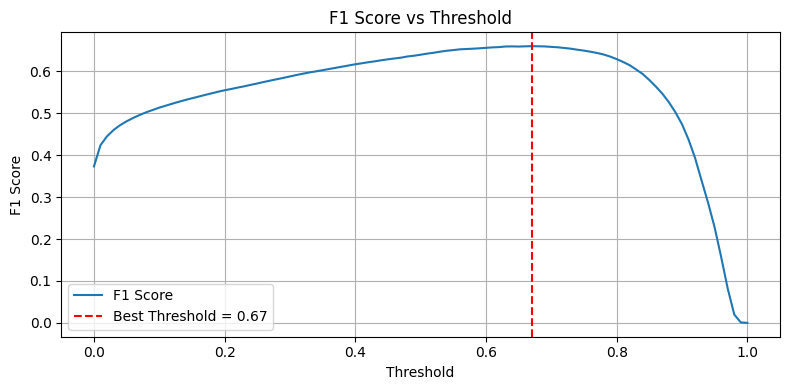

In [12]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_sm)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, F1: {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled, y_sm)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_sm, y_sm)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 08:19:13,722] A new study created in memory with name: no-name-1c248f82-23c3-4783-a52a-57970c052d01
[I 2025-05-04 08:19:26,372] Trial 0 finished with value: 0.6422979147487817 and parameters: {'iterations': 122, 'depth': 5, 'learning_rate': 0.019343552934271778}. Best is trial 0 with value: 0.6422979147487817.
[I 2025-05-04 08:19:57,095] Trial 1 finished with value: 0.671923907994911 and parameters: {'iterations': 247, 'depth': 7, 'learning_rate': 0.08660364427548557}. Best is trial 1 with value: 0.671923907994911.
[I 2025-05-04 08:20:14,017] Trial 2 finished with value: 0.6577801857006743 and parameters: {'iterations': 161, 'depth': 5, 'learning_rate': 0.1015674295890748}. Best is trial 1 with value: 0.671923907994911.
[I 2025-05-04 08:20:27,807] Trial 3 finished with value: 0.6661531958859719 and parameters: {'iterations': 108, 'depth': 7, 'learning_rate': 0.13635108820088576}. Best is trial 1 with value: 0.671923907994911.
[I 2025-05-04 08:20:51,452] Trial 4 finished w

Best trial:
FrozenTrial(number=22, state=1, values=[0.6786683057166949], datetime_start=datetime.datetime(2025, 5, 4, 8, 32, 0, 898458), datetime_complete=datetime.datetime(2025, 5, 4, 8, 32, 43, 329866), params={'iterations': 384, 'depth': 6, 'learning_rate': 0.10798531451378443}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=22, value=None)
Best F1 Score: 0.6786683057166949
Best hyperparameters:
iterations: 384
depth: 6
learning_rate: 0.10798531451378443

Classification report with threshold = 0.67:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90    159566
           1       0.64      0.69      0.67     47528

    accuracy                           0.84    207094
   macro avg       0.78      0.7

In [50]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=395,
#     depth=4,
#     learning_rate=0.10643275132479328,
#     # scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_sm, y_sm)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.7
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

### 5.2.3 SMOTE ENN

In [ ]:
# SMOTE ENN
from imblearn.combine import SMOTEENN

smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [52]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_smenn, y_smenn)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

Learning rate set to 0.162958
0:	learn: 0.5796741	total: 93.2ms	remaining: 1m 33s
1:	learn: 0.5083997	total: 192ms	remaining: 1m 35s
2:	learn: 0.4598074	total: 281ms	remaining: 1m 33s
3:	learn: 0.4295431	total: 376ms	remaining: 1m 33s
4:	learn: 0.4050647	total: 468ms	remaining: 1m 33s
5:	learn: 0.3881938	total: 559ms	remaining: 1m 32s
6:	learn: 0.3744345	total: 647ms	remaining: 1m 31s
7:	learn: 0.3644288	total: 740ms	remaining: 1m 31s
8:	learn: 0.3558942	total: 825ms	remaining: 1m 30s
9:	learn: 0.3483636	total: 917ms	remaining: 1m 30s
10:	learn: 0.3421594	total: 1.01s	remaining: 1m 31s
11:	learn: 0.3376243	total: 1.11s	remaining: 1m 31s
12:	learn: 0.3325926	total: 1.19s	remaining: 1m 30s
13:	learn: 0.3276105	total: 1.28s	remaining: 1m 30s
14:	learn: 0.3243448	total: 1.37s	remaining: 1m 30s
15:	learn: 0.3206091	total: 1.46s	remaining: 1m 29s
16:	learn: 0.3176327	total: 1.55s	remaining: 1m 29s
17:	learn: 0.3145837	total: 1.64s	remaining: 1m 29s
18:	learn: 0.3105605	total: 1.73s	remaining

In [53]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled, y_smenn)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

Learning rate set to 0.162958
0:	learn: 0.5796743	total: 94ms	remaining: 1m 33s
1:	learn: 0.5073263	total: 193ms	remaining: 1m 36s
2:	learn: 0.4596876	total: 287ms	remaining: 1m 35s
3:	learn: 0.4282209	total: 383ms	remaining: 1m 35s
4:	learn: 0.4046468	total: 470ms	remaining: 1m 33s
5:	learn: 0.3880330	total: 557ms	remaining: 1m 32s
6:	learn: 0.3748547	total: 647ms	remaining: 1m 31s
7:	learn: 0.3662102	total: 736ms	remaining: 1m 31s
8:	learn: 0.3567820	total: 828ms	remaining: 1m 31s
9:	learn: 0.3499713	total: 921ms	remaining: 1m 31s
10:	learn: 0.3442401	total: 1.01s	remaining: 1m 31s
11:	learn: 0.3381178	total: 1.1s	remaining: 1m 31s
12:	learn: 0.3329508	total: 1.19s	remaining: 1m 30s
13:	learn: 0.3287520	total: 1.28s	remaining: 1m 30s
14:	learn: 0.3249699	total: 1.37s	remaining: 1m 29s
15:	learn: 0.3220175	total: 1.45s	remaining: 1m 29s
16:	learn: 0.3190547	total: 1.54s	remaining: 1m 28s
17:	learn: 0.3129285	total: 1.63s	remaining: 1m 29s
18:	learn: 0.3103993	total: 1.72s	remaining: 1

In [54]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled[top_features], y_smenn)

# Predict
y_pred = cat_model.predict(X_test_selected)

print_scores(y_test, y_pred)

Learning rate set to 0.162958
0:	learn: 0.5895211	total: 75.5ms	remaining: 1m 15s
1:	learn: 0.5159125	total: 153ms	remaining: 1m 16s
2:	learn: 0.4690284	total: 226ms	remaining: 1m 15s
3:	learn: 0.4346735	total: 300ms	remaining: 1m 14s
4:	learn: 0.4094712	total: 378ms	remaining: 1m 15s
5:	learn: 0.3927307	total: 462ms	remaining: 1m 16s
6:	learn: 0.3785084	total: 538ms	remaining: 1m 16s
7:	learn: 0.3677902	total: 635ms	remaining: 1m 18s
8:	learn: 0.3604034	total: 733ms	remaining: 1m 20s
9:	learn: 0.3535226	total: 809ms	remaining: 1m 20s
10:	learn: 0.3472441	total: 880ms	remaining: 1m 19s
11:	learn: 0.3427520	total: 957ms	remaining: 1m 18s
12:	learn: 0.3382376	total: 1.03s	remaining: 1m 18s
13:	learn: 0.3348608	total: 1.1s	remaining: 1m 17s
14:	learn: 0.3319610	total: 1.17s	remaining: 1m 16s
15:	learn: 0.3282152	total: 1.24s	remaining: 1m 16s
16:	learn: 0.3250177	total: 1.33s	remaining: 1m 16s
17:	learn: 0.3217558	total: 1.4s	remaining: 1m 16s
18:	learn: 0.3196670	total: 1.47s	remaining: 

=> Không chọn đặc trưng, scale cũng có cải thiện.

In [55]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_smenn, y_smenn)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    159566
           1       0.49      0.89      0.63     47528

    accuracy                           0.76    207094
   macro avg       0.72      0.81      0.73    207094
weighted avg       0.85      0.76      0.78    207094



In [56]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_smenn, y_smenn)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.48      0.65    159566
           1       0.36      0.97      0.53     47528

    accuracy                           0.60    207094
   macro avg       0.67      0.73      0.59    207094
weighted avg       0.84      0.60      0.62    207094



=> Không dùng scale_pos_weight

In [57]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled, y_smenn)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    159566
           1       0.49      0.89      0.63     47528

    accuracy                           0.76    207094
   macro avg       0.72      0.81      0.73    207094
weighted avg       0.85      0.76      0.78    207094



=> Dùng scale hay không đều được

In [58]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled[top_features], y_smenn)

# Predict
y_pred = cat_model.predict(X_test_selected)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80    159566
           1       0.46      0.90      0.61     47528

    accuracy                           0.73    207094
   macro avg       0.71      0.79      0.70    207094
weighted avg       0.84      0.73      0.76    207094



**Tuning CatBoost chỉ SMOTE ENN với Optuna**

Best Threshold: 0.77, Best F1 Score : 0.6739482354733655


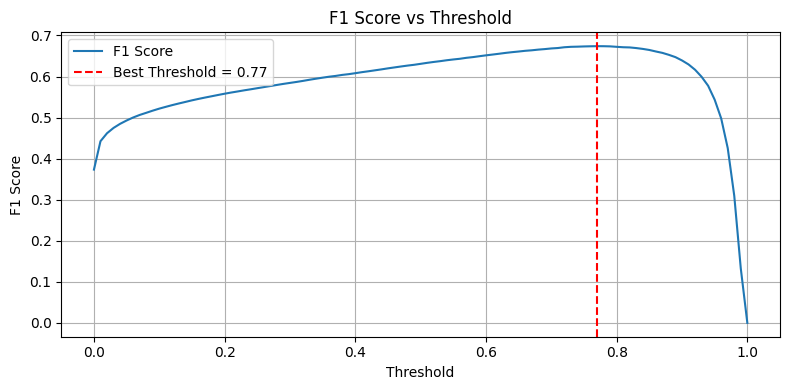

In [59]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_smenn, y_smenn)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, Best F1 Score : {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  # Đừng quá cao
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_smenn, y_smenn)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_smenn, y_smenn)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-03 18:24:33,258] A new study created in memory with name: no-name-9ef43f04-ff5b-409c-a3af-29025c564ef5
[I 2025-05-03 18:25:03,531] Trial 0 finished with value: 0.6755049345294591 and parameters: {'iterations': 248, 'depth': 8, 'learning_rate': 0.12445049177680209}. Best is trial 0 with value: 0.6755049345294591.
[I 2025-05-03 18:25:47,811] Trial 1 finished with value: 0.6887262136686542 and parameters: {'iterations': 474, 'depth': 6, 'learning_rate': 0.07339345592151177}. Best is trial 1 with value: 0.6887262136686542.
[I 2025-05-03 18:26:20,672] Trial 2 finished with value: 0.675309369475545 and parameters: {'iterations': 350, 'depth': 6, 'learning_rate': 0.138096808066147}. Best is trial 1 with value: 0.6887262136686542.
[I 2025-05-03 18:26:58,623] Trial 3 finished with value: 0.6656407119233784 and parameters: {'iterations': 408, 'depth': 6, 'learning_rate': 0.027024676916808932}. Best is trial 1 with value: 0.6887262136686542.
[I 2025-05-03 18:27:33,975] Trial 4 finished

Best trial:
FrozenTrial(number=21, state=1, values=[0.6901659686675973], datetime_start=datetime.datetime(2025, 5, 3, 18, 36, 17, 45200), datetime_complete=datetime.datetime(2025, 5, 3, 18, 36, 44, 532494), params={'iterations': 332, 'depth': 5, 'learning_rate': 0.11918950786056129}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=21, value=None)
Best F1 Score: 0.6901659686675973
Best hyperparameters:
iterations: 332
depth: 5
learning_rate: 0.11918950786056129

Classification report with threshold = 0.77:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90    159566
           1       0.64      0.75      0.69     47528

    accuracy                           0.85    207094
   macro avg       0.78      0

In [61]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=434,
#     depth=6,
#     learning_rate=0.097919302671831,
#     # scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_smenn, y_smenn)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.77
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

**Tuning CatBoost SMOTE ENN và đã chuẩn hóa với Optuna**

Best Threshold: 0.77, Best F1 Score : 0.6738742217288479


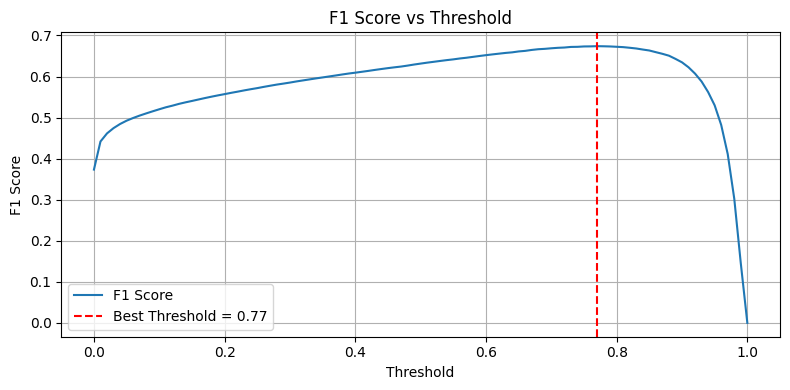

In [62]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_smenn)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, Best F1 Score : {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  # Đừng quá cao
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled, y_smenn)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_scaled, y_smenn)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-03 18:41:52,961] A new study created in memory with name: no-name-1284c270-656d-4808-9d66-7552144721e8
[I 2025-05-03 18:42:03,945] Trial 0 finished with value: 0.6629748463560424 and parameters: {'iterations': 127, 'depth': 5, 'learning_rate': 0.11252129708378675}. Best is trial 0 with value: 0.6629748463560424.
[I 2025-05-03 18:42:45,012] Trial 1 finished with value: 0.6799458780322799 and parameters: {'iterations': 443, 'depth': 6, 'learning_rate': 0.133519271285869}. Best is trial 1 with value: 0.6799458780322799.
[I 2025-05-03 18:43:09,946] Trial 2 finished with value: 0.6697351841631174 and parameters: {'iterations': 203, 'depth': 8, 'learning_rate': 0.14344921587695325}. Best is trial 1 with value: 0.6799458780322799.
[I 2025-05-03 18:43:34,874] Trial 3 finished with value: 0.683409899011666 and parameters: {'iterations': 260, 'depth': 6, 'learning_rate': 0.11863265764036453}. Best is trial 3 with value: 0.683409899011666.
[I 2025-05-03 18:43:58,142] Trial 4 finished w

Best trial:
FrozenTrial(number=21, state=1, values=[0.6854828937270266], datetime_start=datetime.datetime(2025, 5, 3, 18, 51, 39, 401537), datetime_complete=datetime.datetime(2025, 5, 3, 18, 52, 10, 291903), params={'iterations': 327, 'depth': 6, 'learning_rate': 0.127730327133488}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=21, value=None)
Best F1 Score: 0.6854828937270266
Best hyperparameters:
iterations: 327
depth: 6
learning_rate: 0.127730327133488

Classification report with threshold = 0.77:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90    159566
           1       0.66      0.71      0.69     47528

    accuracy                           0.85    207094
   macro avg       0.79      0.80

In [64]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=452,
#     depth=4,
#     learning_rate=0.12655128193358028,
#     # scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train_scaled, y_smenn)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test_scaled)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.76
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled[top_features], y_smenn)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled[top_features])[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, Best F1 Score : {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  # Đừng quá cao
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled[top_features], y_smenn)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled[top_features])[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_scaled, y_smenn)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

# 7. Kết luận

* Nếu **muốn mô hình ổn định, đơn giản, không xử lý dữ liệu phức tạp** → **Chọn mô hình gốc dùng `scale_pos_weight`**
* Nếu **ưu tiên recall cao nhất (bắt hết mưa)**, chấp nhận nhiều cảnh báo giả → **Chọn mô hình SMOTEENN + chuẩn hóa**
* Nếu **ưu tiên precision cao (giảm cảnh báo giả)**, chấp nhận một số mưa bị bỏ sót → **Chọn mô hình SMOTE**

Cả 3 mô hình có f1 bằng nhau.